In [1]:
import sys
import pickle
sys.path.append('../..')
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from lstm import transf_chik_pred
from lstm import apply_dengue_chik
from preprocessing import get_nn_data
from lstm import build_model, transf_chik_pred, transf_model
from pgbm_model import  cross_dengue_chik_prediction
from sklearn.metrics import mean_squared_error as mse 
import matplotlib.dates as mdates
from plots_pgbm import predicted_vs_observed as p_o_pgbm
from plots_lstm import plot_loss
fmt = mdates.DateFormatter('%d-%b\n%Y')

In [2]:
CITY = 2304400
CITY_NAME = 'Fortaleza'
STATE = 'CE'
FILENAME_DATA = f'../../data/chik_{CITY}_cluster.csv'

In [3]:
df_chik = pd.read_csv(FILENAME_DATA, index_col = 'Unnamed: 0' )
df_chik.index = pd.to_datetime(df_chik.index)
df_chik

,casos_2307650,casos_est_2307650,casos_est_min_2307650,casos_est_max_2307650,p_rt1_2307650,p_inc100k_2307650,temp_min_2307650,temp_max_2307650,umid_min_2307650,pressao_min_2307650,...,casos_2302008,casos_est_2302008,casos_est_min_2302008,casos_est_max_2302008,p_rt1_2302008,p_inc100k_2302008,temp_min_2302008,temp_max_2302008,umid_min_2302008,pressao_min_2302008
2010-01-03,0,0.0,0,0,0.000000,0.000000,24.319912,30.486346,60.977150,0.996031,...,0,0.0,0,0,0.000000,0.000000,22.640307,30.403224,54.970053,0.996096
2010-01-10,0,0.0,0,0,0.000000,0.000000,24.411634,30.839578,57.369000,0.996246,...,0,0.0,0,0,0.000000,0.000000,22.182997,29.993391,56.564824,0.996851
2010-01-17,0,0.0,0,0,0.000000,0.000000,24.750937,32.868508,48.148234,0.997115,...,0,0.0,0,0,0.000000,0.000000,22.574323,31.373539,51.559022,0.997896
2010-01-24,0,0.0,0,0,0.000000,0.000000,24.381592,32.757769,52.469240,0.995866,...,0,0.0,0,0,0.000000,0.000000,22.169896,31.661416,50.600249,0.996541
2010-01-31,0,0.0,0,0,0.000000,0.000000,24.674992,31.494088,57.549285,0.995062,...,0,0.0,0,0,0.000000,0.000000,22.813411,31.559658,51.487102,0.995551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-19,18,25.0,19,43,0.861271,10.895240,22.944916,27.709486,75.758353,0.997039,...,0,0.0,0,2,0.000000,0.000000,22.074554,28.264007,64.974941,0.997236
2023-03-26,16,24.0,17,45,0.686689,10.459431,22.866660,29.595206,65.729017,0.997306,...,0,0.0,0,4,0.000000,0.000000,21.513641,28.862170,61.803014,0.998119
2023-04-02,5,15.0,6,46,0.106304,6.537144,23.083509,28.595555,74.222116,0.997248,...,1,3.0,1,10,0.930414,13.182178,21.488054,29.833902,56.197920,0.997743
2023-04-09,5,18.0,6,62,0.292376,7.844573,22.753963,28.771785,73.798959,0.996171,...,4,12.0,4,55,0.999303,52.728710,22.208356,29.759373,59.601682,0.996064


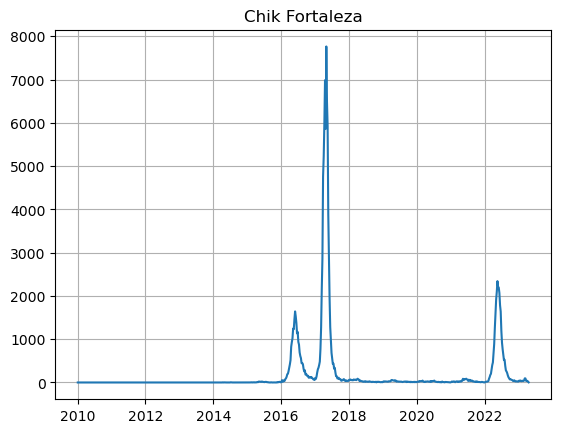

In [4]:
fig, ax = plt.subplots()

ax.plot(df_chik[f'casos_2304400'])

ax.set_title('Chik Fortaleza')
plt.grid()
plt.show()

In [5]:
INI_DATE = '2015-11-01'
END_DATE_TRAIN = '2017-12-01'
END_DATE = '2023-01-01'

PREDICT_N = 4 # number of new days predicted
LOOK_BACK = 4 # number of last days used to make the prediction 
EPOCHS = 400
HIDDEN = 8
FEAT = 126 # number of features 

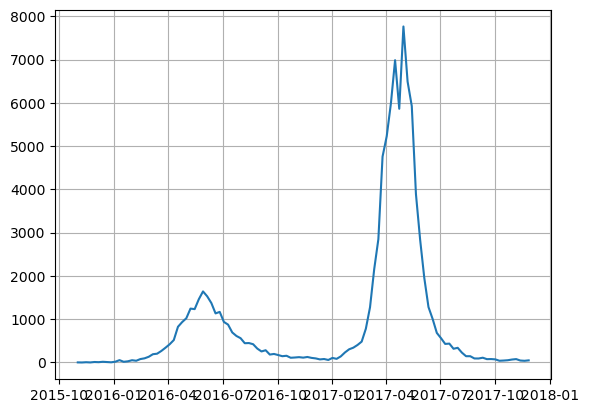

In [6]:
fig, ax = plt.subplots()

ax.plot(df_chik.loc[INI_DATE:END_DATE_TRAIN]['casos_2304400'])

ax.grid()

plt.show()

Apply the dengue model:

2023-05-06 23:55:02.267429: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


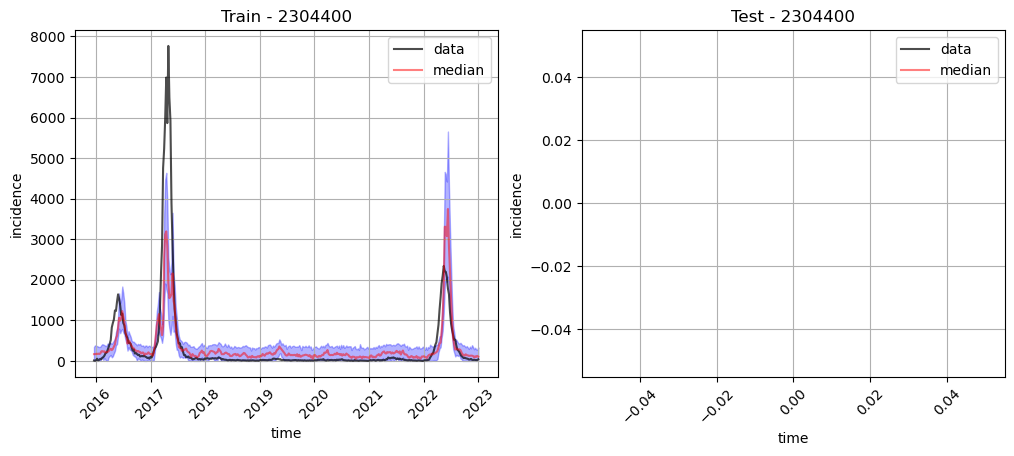

In [7]:
metrics = apply_dengue_chik(CITY, ini_date = INI_DATE, 
                         end_date = END_DATE, look_back = LOOK_BACK, batch_size = 1, 
                         predict_n = PREDICT_N,  label_m = f'msle_all', filename = FILENAME_DATA  )

Applying the **transfer learning** techinique:

- Using the model trained with `loss = 'msle'`:


Compilation Time :  0.0016570091247558594
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 126)]          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 4, 8)             8640      
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 4, 8)              0         
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 4)                 36        
                   

91/91 [==============================] - 0s 3ms/step - loss: 0.0017 - accuracy: 0.3956 - mape: 143.5615 - mse: 0.0026 - val_loss: 0.0045 - val_accuracy: 0.5455 - val_mape: 55.1269 - val_mse: 0.0072
Epoch 34/100
91/91 [==============================] - 0s 3ms/step - loss: 0.0023 - accuracy: 0.3297 - mape: 189.6995 - mse: 0.0042 - val_loss: 0.0039 - val_accuracy: 0.6364 - val_mape: 50.4901 - val_mse: 0.0053
Epoch 35/100
91/91 [==============================] - 0s 3ms/step - loss: 0.0018 - accuracy: 0.4835 - mape: 136.0931 - mse: 0.0030 - val_loss: 0.0035 - val_accuracy: 0.4545 - val_mape: 44.6848 - val_mse: 0.0052
Epoch 36/100
91/91 [==============================] - 0s 3ms/step - loss: 0.0017 - accuracy: 0.4396 - mape: 130.5819 - mse: 0.0029 - val_loss: 0.0050 - val_accuracy: 0.5455 - val_mape: 62.5466 - val_mse: 0.0088
Epoch 37/100
91/91 [==============================] - 0s 3ms/step - loss: 0.0029 - accuracy: 0.3846 - mape: 129.7328 - mse: 0.0056 - val_loss: 0.0020 - val_accuracy: 0.4

Epoch 72/100
91/91 [==============================] - 0s 3ms/step - loss: 0.0018 - accuracy: 0.4286 - mape: 97.1628 - mse: 0.0032 - val_loss: 0.0031 - val_accuracy: 0.4545 - val_mape: 44.9261 - val_mse: 0.0050
Epoch 73/100
91/91 [==============================] - 0s 3ms/step - loss: 0.0017 - accuracy: 0.4835 - mape: 218.9882 - mse: 0.0030 - val_loss: 0.0028 - val_accuracy: 0.6364 - val_mape: 52.6146 - val_mse: 0.0052
Epoch 74/100
91/91 [==============================] - 0s 3ms/step - loss: 0.0018 - accuracy: 0.5165 - mape: 106.5210 - mse: 0.0034 - val_loss: 0.0048 - val_accuracy: 0.6364 - val_mape: 37.1784 - val_mse: 0.0096
Epoch 75/100
91/91 [==============================] - 0s 4ms/step - loss: 0.0013 - accuracy: 0.5385 - mape: 107.7082 - mse: 0.0023 - val_loss: 0.0045 - val_accuracy: 0.5455 - val_mape: 36.9954 - val_mse: 0.0072


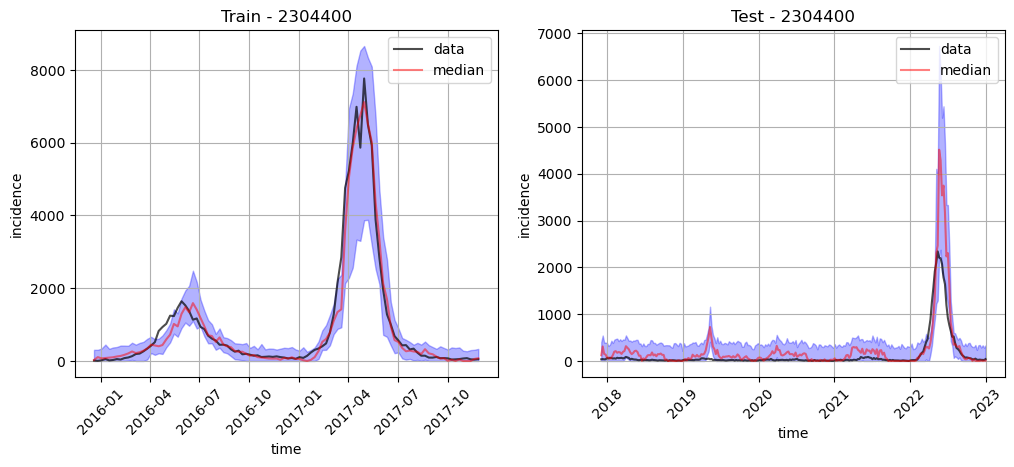

In [8]:

l1 = 1e-6
l2 = 1e-6
BATCH_SIZE = 1
EPOCHS = 100
filename = f'../../saved_models/lstm/trained_{CITY}_model_msle_all.h5'
model = transf_model(filename, l1,l2,HIDDEN, FEAT, PREDICT_N, LOOK_BACK, batch_size = BATCH_SIZE, lr = 0.0001)
    
m_msle, hist, m_t, m_val = transf_chik_pred(model, CITY, ini_date = INI_DATE, end_train_date = END_DATE_TRAIN,  
                                end_date = END_DATE,  epochs= EPOCHS, 
                                predict_n = PREDICT_N, look_back = LOOK_BACK, validation_split = 0.1, monitor = 'val_loss', patience = 20, 
                                label = f'transf_msle', filename_data = FILENAME_DATA,  )

Apply the pgbm model:

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


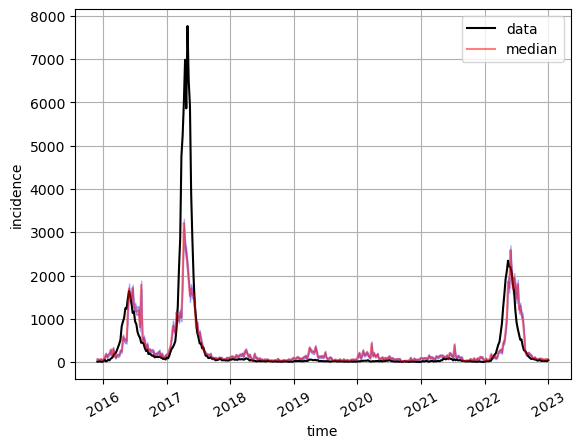

In [9]:
preds, preds25, preds975, X_data, targets = cross_dengue_chik_prediction(CITY, STATE, predict_n = PREDICT_N, look_back = LOOK_BACK, ini_date = INI_DATE, end_date = END_DATE, filename = FILENAME_DATA )
    